# task2

### notes

In [168]:
# features that probably will corelate
# temperature
# time of day
# day of week
# weather conditions
# (before) public holiday

# more features
# school/university holidays
# gas prize
# inflation

In [169]:
# imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

## READ DATA

In [170]:
# import all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette("GnBu_d")

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')

import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
import math
import random
#import timeit

In [171]:
tripdata = pd.read_csv("../boston_2016.csv", encoding = "ISO-8859-1")
#data.sort_values(["car ID","timestamp"], inplace=True)
#data.set_index(pd.DatetimeIndex(STR_Nov["timestamp"]),inplace=True)
#data.drop("timestamp", axis=1, inplace=True)

tripdata['start_time'] = pd.to_datetime(tripdata['start_time'])

In [172]:
tripdata

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2016-01-01 00:08:07.000,2016-01-01 00:40:26,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1406,Subscriber
1,2016-01-01 00:08:19.000,2016-01-01 00:40:27,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1121,Subscriber
2,2016-01-01 00:10:15.000,2016-01-01 00:40:29,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,474,Subscriber
3,2016-01-01 00:10:22.000,2016-01-01 00:40:11,36,19,Boston Public Library - 700 Boylston St.,Buswell St. at Park Dr.,1504,Subscriber
4,2016-01-01 00:15:36.000,2016-01-01 00:31:17,36,67,Boston Public Library - 700 Boylston St.,MIT at Mass Ave / Amherst St,913,Customer
...,...,...,...,...,...,...,...,...
1236198,2016-12-31 23:01:46.254,2016-12-31 23:14:20.6250,8,33,Union Square - Brighton Ave at Cambridge St,Kenmore Square,230,Subscriber
1236199,2016-12-31 23:14:21.233,2016-12-31 23:18:03.1850,190,6,Nashua Street at Red Auerbach Way,Cambridge St at Joy St,1420,Subscriber
1236200,2016-12-31 23:15:38.580,2016-12-31 23:24:43.0190,33,36,Kenmore Square,Copley Square - Dartmouth St at Boylston St,230,Subscriber
1236201,2016-12-31 23:20:35.796,2016-12-31 23:27:58.5830,90,141,Lechmere Station at Cambridge St / First St,Kendall Street,74,Subscriber


In [173]:
#test data type
type(tripdata['start_time'][0])

pandas._libs.tslibs.timestamps.Timestamp

# WEATHER DATA

In [174]:
weather_data = pd.read_csv("../weather_hourly_boston.csv", encoding = "ISO-8859-1")

weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

In [175]:
start = pd.to_datetime(datetime(year=2016, month=1, day=1))
end = pd.to_datetime(datetime(year=2017, month=1, day=1))

weather_data_16 = weather_data[(weather_data["date_time"]>=start)&(weather_data["date_time"]<=end)]

In [210]:
weather_data_16['precip'] = weather_data_16['precip'].apply(np.int64)
weather_data_16['avg_temp'] = (weather_data_16['max_temp'] + weather_data_16['min_temp'])/2

weather_data_16 = weather_data_16.sort_values(by=['date_time'], ascending=True)

weather_data_16 = weather_data_16.drop_duplicates(subset='date_time', keep='first')

weather_data_16.index = range(8251)

In [211]:
weather_data_16

,date_time,max_temp,min_temp,precip,avg_temp
0,2016-01-01 00:00:00,5.6,5.6,0,5.6
1,2016-01-01 01:00:00,5.0,5.0,0,5.0
2,2016-01-01 02:00:00,5.0,5.0,0,5.0
3,2016-01-01 03:00:00,4.4,4.4,0,4.4
4,2016-01-01 04:00:00,4.4,4.4,0,4.4
...,...,...,...,...,...
8246,2016-12-31 20:00:00,1.7,1.7,0,1.7
8247,2016-12-31 21:00:00,1.7,1.7,0,1.7
8248,2016-12-31 22:00:00,2.2,2.2,0,2.2
8249,2016-12-31 23:00:00,3.3,3.3,0,3.3


## PROCESS / CLEAN DATA

### Determine most popular station

Most popular rental station: 67 MIT at Mass Ave / Amherst St

In [212]:
tripdata67 = tripdata.where(lambda x: (x.start_station_id == 67), axis = 0)
tripdata67['start_time'] = pd.to_datetime(tripdata67['start_time'])

In [213]:
# set hourly Dataframe
tripdata67_hourly = tripdata67.set_index('start_time')

# get outoing trips
tripdata67_hourly = tripdata67_hourly.resample('H').count()

tripdata67_hourly = tripdata67_hourly.drop('start_station_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('end_station_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('start_station_name', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('end_station_name', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('bike_id', axis=1)
tripdata67_hourly = tripdata67_hourly.drop('user_type', axis=1)
tripdata67_hourly.rename(columns = {'end_time':'trips_out'}, inplace = True)

tripdata67_hourly = tripdata67_hourly.reset_index()

tripdata67_hourly.rename(columns = {'start_time':'date_time'}, inplace = True)

tripdata67_hourly.index = range(8, 8782)

data = [[pd.to_datetime('2016-01-01 00:00:00'),0],
        [pd.to_datetime('2016-01-01 01:00:00'),0],
        [pd.to_datetime('2016-01-01 02:00:00'),0],
        [pd.to_datetime('2016-01-01 03:00:00'),0],
        [pd.to_datetime('2016-01-01 04:00:00'),0],
        [pd.to_datetime('2016-01-01 05:00:00'),0],
        [pd.to_datetime('2016-01-01 06:00:00'),0],
        [pd.to_datetime('2016-01-01 07:00:00'),0]]

data2 = [[pd.to_datetime('2016-12-31 22:00:00'),0],
         [pd.to_datetime('2016-12-31 23:00:00'),0],
         [pd.to_datetime('2017-01-01 00:00:00'),0]]
 
# Create help dataframes
df = pd.DataFrame(data, range(8), columns=['date_time', 'trips_out'])
df2 = pd.DataFrame(data2, range(8782, 8785), columns=['date_time', 'trips_out'])

tripdata67_hourly = tripdata67_hourly.append(df, ignore_index=False)
tripdata67_hourly = tripdata67_hourly.append(df2, ignore_index=False)

tripdata67_hourly = tripdata67_hourly.sort_index()

In [214]:
tripdata67_hourly

,date_time,trips_out
0,2016-01-01 00:00:00,0
1,2016-01-01 01:00:00,0
2,2016-01-01 02:00:00,0
3,2016-01-01 03:00:00,0
4,2016-01-01 04:00:00,0
...,...,...
8780,2016-12-31 20:00:00,1
8781,2016-12-31 21:00:00,2
8782,2016-12-31 22:00:00,0
8783,2016-12-31 23:00:00,0


In [215]:
weather_data_16['date_time'].iloc[0]

Timestamp('2016-01-01 00:00:00')

## ADD WEATHER DATA

In [227]:
data_max = []
data_min = []
data_pre = []
data_avg = []

count_w = 0
for i in range(8785):
    if tripdata67_hourly['date_time'].iloc[i] == weather_data_16['date_time'].iloc[count_w]:
        data_max.append(weather_data_16['max_temp'].iloc[count_w])
        data_min.append(weather_data_16['min_temp'].iloc[count_w])
        data_pre.append(weather_data_16['precip'].iloc[count_w])
        data_avg.append(weather_data_16['avg_temp'].iloc[count_w])
        count_w = count_w + 1
    else:
        data_max.append(None)
        data_min.append(None)
        data_pre.append(None)
        data_avg.append(None)
        
data_max = pd.Series(data_max)
data_min = pd.Series(data_min)
data_pre = pd.Series(data_pre)
data_avg = pd.Series(data_avg)

tripdata67_hourly['max_temp'] = data_max
tripdata67_hourly['min_temp'] = data_min
tripdata67_hourly['precip'] = data_pre
tripdata67_hourly['avg_temp'] = data_avg

for i in range(8785):
    if np.isnan(tripdata67_hourly['max_temp'].iloc[i]):
        if np.isnan(tripdata67_hourly['max_temp'].iloc[i+1]):
            tripdata67_hourly['max_temp'].iloc[i] = tripdata67_hourly['max_temp'].iloc[i-1]
            tripdata67_hourly['min_temp'].iloc[i] = tripdata67_hourly['min_temp'].iloc[i-1]
        else:
            tripdata67_hourly['max_temp'].iloc[i] = (tripdata67_hourly['max_temp'].iloc[i-1]+tripdata67_hourly['max_temp'].iloc[i+1])/2
            tripdata67_hourly['min_temp'].iloc[i] = (tripdata67_hourly['min_temp'].iloc[i-1]+tripdata67_hourly['min_temp'].iloc[i+1])/2
        
        tripdata67_hourly['precip'].iloc[i] = tripdata67_hourly['precip'].iloc[i-1]
        #tripdata67_hourly['avg_temp'].iloc[i] = (tripdata67_hourly['avg_temp'].iloc[i-1]+tripdata67_hourly['avg_temp'].iloc[i+1])/2
        

tripdata67_hourly['avg_temp'] = (tripdata67_hourly['max_temp'] + tripdata67_hourly['min_temp'])/2

In [228]:
#weekday feature (0: monday, 1: tuesday, ...)

tripdata67_hourly['weekday'] = tripdata67_hourly.apply(lambda x: (x.date_time.weekday()), axis=1)

In [229]:
tripdata67_hourly

,date_time,trips_out,max_temp,min_temp,precip,avg_temp,weekday
0,2016-01-01 00:00:00,0,5.6,5.6,0.0,5.6,4
1,2016-01-01 01:00:00,0,5.0,5.0,0.0,5.0,4
2,2016-01-01 02:00:00,0,5.0,5.0,0.0,5.0,4
3,2016-01-01 03:00:00,0,4.4,4.4,0.0,4.4,4
4,2016-01-01 04:00:00,0,4.4,4.4,0.0,4.4,4
...,...,...,...,...,...,...,...
8780,2016-12-31 20:00:00,1,1.7,1.7,0.0,1.7,5
8781,2016-12-31 21:00:00,2,1.7,1.7,0.0,1.7,5
8782,2016-12-31 22:00:00,0,2.2,2.2,0.0,2.2,5
8783,2016-12-31 23:00:00,0,3.3,3.3,0.0,3.3,5


In [190]:
tripdata67_hourly

,date_time,trips_out,max_temp,min_temp,precip,avg_temp,weekday
8,2016-01-01 08:00:00,1,3.3,3.3,0.0,3.3,4
10,2016-01-01 10:00:00,1,3.3,3.3,0.0,3.3,4
13,2016-01-01 13:00:00,1,2.2,2.2,0.0,2.2,4
14,2016-01-01 14:00:00,3,3.3,3.3,0.0,3.3,4
16,2016-01-01 16:00:00,1,4.4,4.4,0.0,4.4,4
...,...,...,...,...,...,...,...
8776,2016-12-31 16:00:00,3,0.6,0.6,0.0,0.6,5
8777,2016-12-31 17:00:00,1,0.6,0.6,0.0,0.6,5
8778,2016-12-31 18:00:00,1,1.1,1.1,0.0,1.1,5
8780,2016-12-31 20:00:00,1,1.7,1.7,0.0,1.7,5


In [230]:
# eliminate hours with no trips
tripdata67_hourly = tripdata67_hourly.drop(tripdata67_hourly[tripdata67_hourly.trips_out == 0].index)

In [231]:
np.any(np.isnan(tripdata67_hourly))

False

In [234]:
check_for_nan = tripdata67_hourly['avg_temp'].isnull().values.any()
print (check_for_nan)

check_for_nan = tripdata67_hourly['avg_temp'].isnull()
print (check_for_nan)

False
8       False
10      False
13      False
14      False
16      False
        ...  
8776    False
8777    False
8778    False
8780    False
8781    False
Name: avg_temp, Length: 5884, dtype: bool


## VISULIZATION / REGRESSION

In [235]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


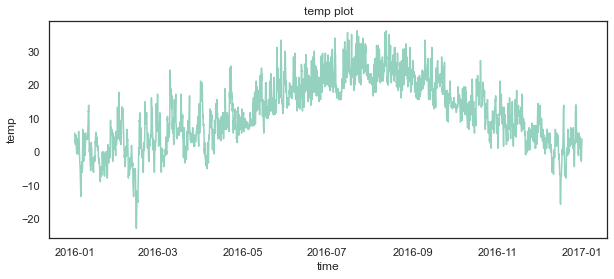

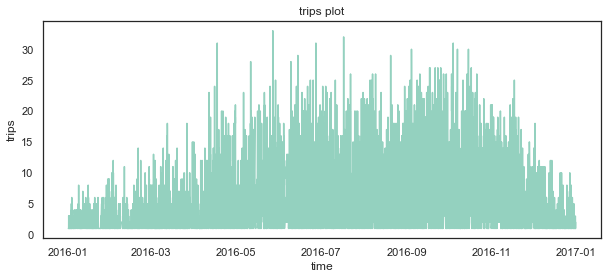

In [236]:
# WEATHER VISUALIZATION
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(weather_data_16["date_time"],weather_data_16["avg_temp"],"-")
ax.set_xlabel("time")
ax.set_ylabel("temp")
ax.set_title("temp plot")
#ax.xlim((start,end))
#ax.ylim((26,38))

#plt.show()

fig,ax2 = plt.subplots(figsize=(10,4))
ax2.plot(tripdata67_hourly["date_time"],tripdata67_hourly["trips_out"],"-")
ax2.set_xlabel("time")
ax2.set_ylabel("trips")
ax2.set_title("trips plot")
#ax.xlim((start,end))
#ax.ylim((26,38))

plt.show()

In [237]:
# define dependent (y) and independent (x) variables for trip demand prediction

xp = tripdata67_hourly["avg_temp"]

yp = tripdata67_hourly["trips_out"]

#min_H_temp, max_H_temp = xp.min(), xp.max()

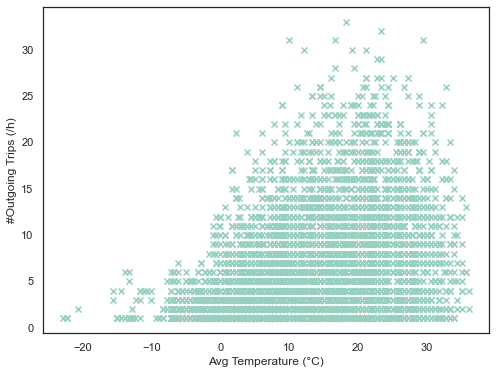

In [238]:
fig, ax = plt.subplots(figsize = (8,6))
# Plotting the data
ax.scatter(xp, yp, marker='x',)
ax.set_xlabel("Avg Temperature (°C)")
ax.set_ylabel("#Outgoing Trips (/h)")

plt.show()
#saving figures (You can comment-out this line inorder not to save figures)
#plt.savefig('summer data_peak demand.pdf')

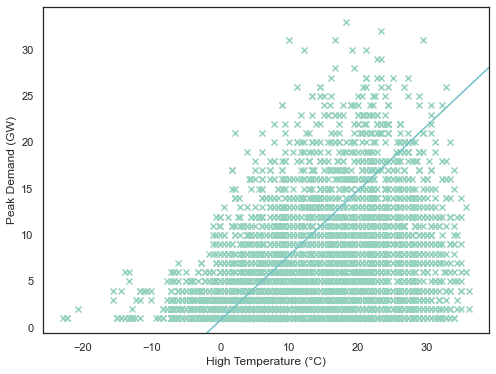

In [239]:
# define theta vector
theta = np.array([0.7, 0.80])

# set up plot
fig, ax = plt.subplots(figsize = (8,6))

# add objects to axis
ax.scatter(xp, yp, marker='x')
xlimp, ylimp =(plt.gca().get_xlim(), plt.gca().get_ylim())  #gets limity of x and y
ax.plot(xlimp, [theta[0]*xlimp[0]+theta[1], theta[0]*xlimp[1]+theta[1]], 'C1')
ax.set_xlim(xlimp)
ax.set_ylim(ylimp)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
plt.show()
#plt.savefig('summer data_peak demand_line.pdf')

In [240]:
# x is the input variable
# y is the output vaiable
# d is degree pf polynomial regression

def plot_regression_poly(x, y, d):
    
    # Create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    # Implement polynomial regression using least squares (we use the nomal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    # create scaled test dataset
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # Plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # prints first 3 thetas

[-4.71753002  0.13865488  7.25152989  4.82939751]


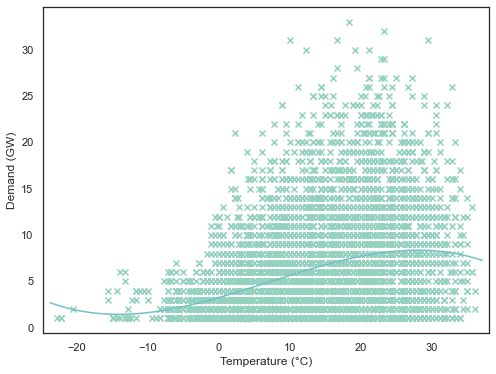

In [248]:
plot_regression_poly(x = xp, y=yp, d = 3)

In [242]:
# rescaling
x_nor = (xp-min(xp))/(max(xp)-min(xp))
y_nor = (yp-min(yp))/(max(yp)-min(yp))

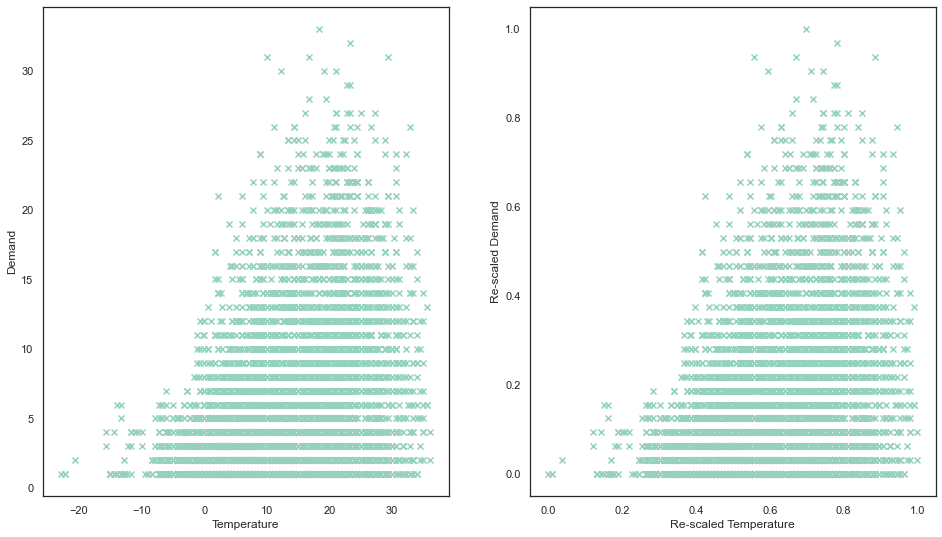

In [243]:
# set up plot
fig, axes = plt.subplots(1,2,figsize = (16,9))

axes[0].scatter(xp, yp, marker='x')
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Demand")

axes[1].scatter(x_nor, y_nor, marker = 'x')
axes[1].set_xlabel("Re-scaled Temperature")
axes[1].set_ylabel("Re-scaled Demand")

plt.show()

In [244]:
theta = np.array([0., 0.])

alpha = 1.0

for t in range(20):
    print("Iteration {}: ".format(t), theta)
    
    # partial derivative theta1: 2*sum(((theta1*x + theta2)-y)*x)
    # term 2/N added here (usully included in alpha term), this is just a constant so could also be omitted
    theta[0] -= alpha/len(xp) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
    
    # partial derivative theta2: 2*sum(((theta1*x + theta2)-y))
    # term 2/N added here (usully included in alpha term), this is just a constant so could also be omitted
    theta[1] -= alpha/len(xp) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) ) # this is the intercept with a slightly different partial derivative

Iteration 0:  [0. 0.]
Iteration 1:  [0.21071427 0.05996378]
Iteration 2:  [0.1814432  0.03559715]
Iteration 3:  [0.20501209 0.03130117]
Iteration 4:  [0.2151191 0.0233058]
Iteration 5:  [0.22693624 0.01693011]
Iteration 6:  [0.2371379  0.01089934]
Iteration 7:  [0.24658545 0.00544075]
Iteration 8:  [0.25518093 0.0004462 ]
Iteration 9:  [ 0.26303556 -0.00411143]
Iteration 10:  [ 0.27020538 -0.00827316]
Iteration 11:  [ 0.27675186 -0.01207274]
Iteration 12:  [ 0.28272879 -0.01554183]
Iteration 13:  [ 0.28818582 -0.01870914]
Iteration 14:  [ 0.29316815 -0.02160094]
Iteration 15:  [ 0.29771707 -0.02424118]
Iteration 16:  [ 0.30187029 -0.02665175]
Iteration 17:  [ 0.30566223 -0.02885263]
Iteration 18:  [ 0.30912432 -0.03086207]
Iteration 19:  [ 0.31228524 -0.0326967 ]


### SCIKITLEARN REGRESSION

[0.18768717] 3.616782170151294


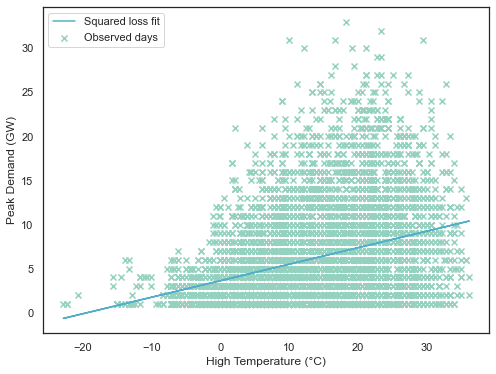

In [245]:
X = tripdata67_hourly["avg_temp"].values.reshape((-1,1)) # if we pass a 1-feature array we need to re-shape it! This is not required for multi-dimenisonal arrays
y = tripdata67_hourly["trips_out"]

# initialize model
lin_mod = LinearRegression()

#train model
lin_mod.fit(X, y)

#make predictions using model
model_pred = lin_mod.predict(X)

# plot resulzts
plt.figure(figsize = (8,6))
plt.scatter(X, y, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(X, model_pred, c='C2')
plt.legend(['Squared loss fit','Observed days'])
print(lin_mod.coef_, lin_mod.intercept_)

# STATION DATA

In [11]:
stationdata = pd.read_csv("../current_bluebikes_stations_new.csv", encoding = "ISO-8859-1")

In [213]:
stationdata

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
422,N32005,West Newton,42.349601,-71.226275,Newton,Yes,15,2020.0
423,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,19,2019.0
424,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
425,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,19,2018.0


In [13]:
stationdata

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0
...,...,...,...,...,...,...,...,...
422,N32005,West Newton,42.349601,-71.226275,Newton,Yes,15,2020.0
423,A32043,Western Ave at Richardson St,42.361787,-71.143931,Boston,Yes,19,2019.0
424,B32059,Whittier St Health Center,42.332863,-71.092189,Boston,Yes,19,2019.0
425,D32040,Williams St at Washington St,42.306539,-71.107669,Boston,Yes,19,2018.0


In [ ]:
----------------------------------------------------------------